# Time Series Analysis of Bitcoin Data

In [1]:
#import libraries

import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
#load bitcoin data

btc = web.get_data_yahoo('BTC-USD', start=datetime.datetime(2017, 1, 1), 
                         end=datetime.datetime(2017, 12, 27))
btc.head()

High          Low         Open        Close     Volume  \
Date                                                                        
2016-12-31   965.469971   942.400024   959.039978   963.380005   26379401   
2017-01-01  1001.609985   956.099976   963.380005   995.440002   40570922   
2017-01-02  1031.680054   990.200012   995.440002  1017.049988   66038073   
2017-01-03  1035.469971  1006.530029  1017.049988  1033.300049   56085870   
2017-01-04  1148.540039  1022.320007  1033.300049  1135.410034  170584623   

              Adj Close  
Date                     
2016-12-31   963.380005  
2017-01-01   995.440002  
2017-01-02  1017.049988  
2017-01-03  1033.300049  
2017-01-04  1135.410034

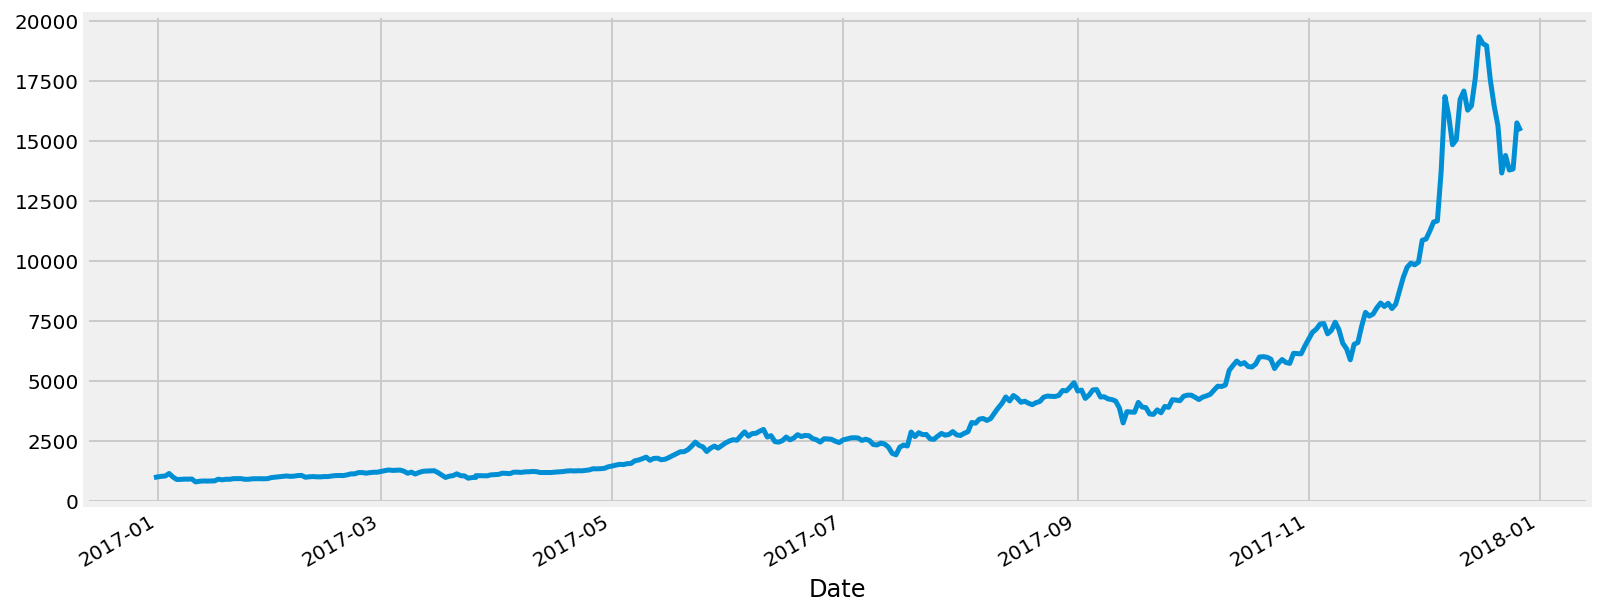

In [3]:
#plot the adjusted closing price

btc_adj = btc['Adj Close']
btc_adj.plot(lw=2.5, figsize=(12, 5))
plt.show()

In [ ]:
#moving average analysis

btc_recent = btc_adj.loc['2017-10-01':'2017-12-27']
rroll_d3 = btc_recent.rolling(window=3).mean()
rroll_d7 = btc_recent.rolling(window=7).mean()
rroll_d14 = btc_recent.rolling(window=14).mean()

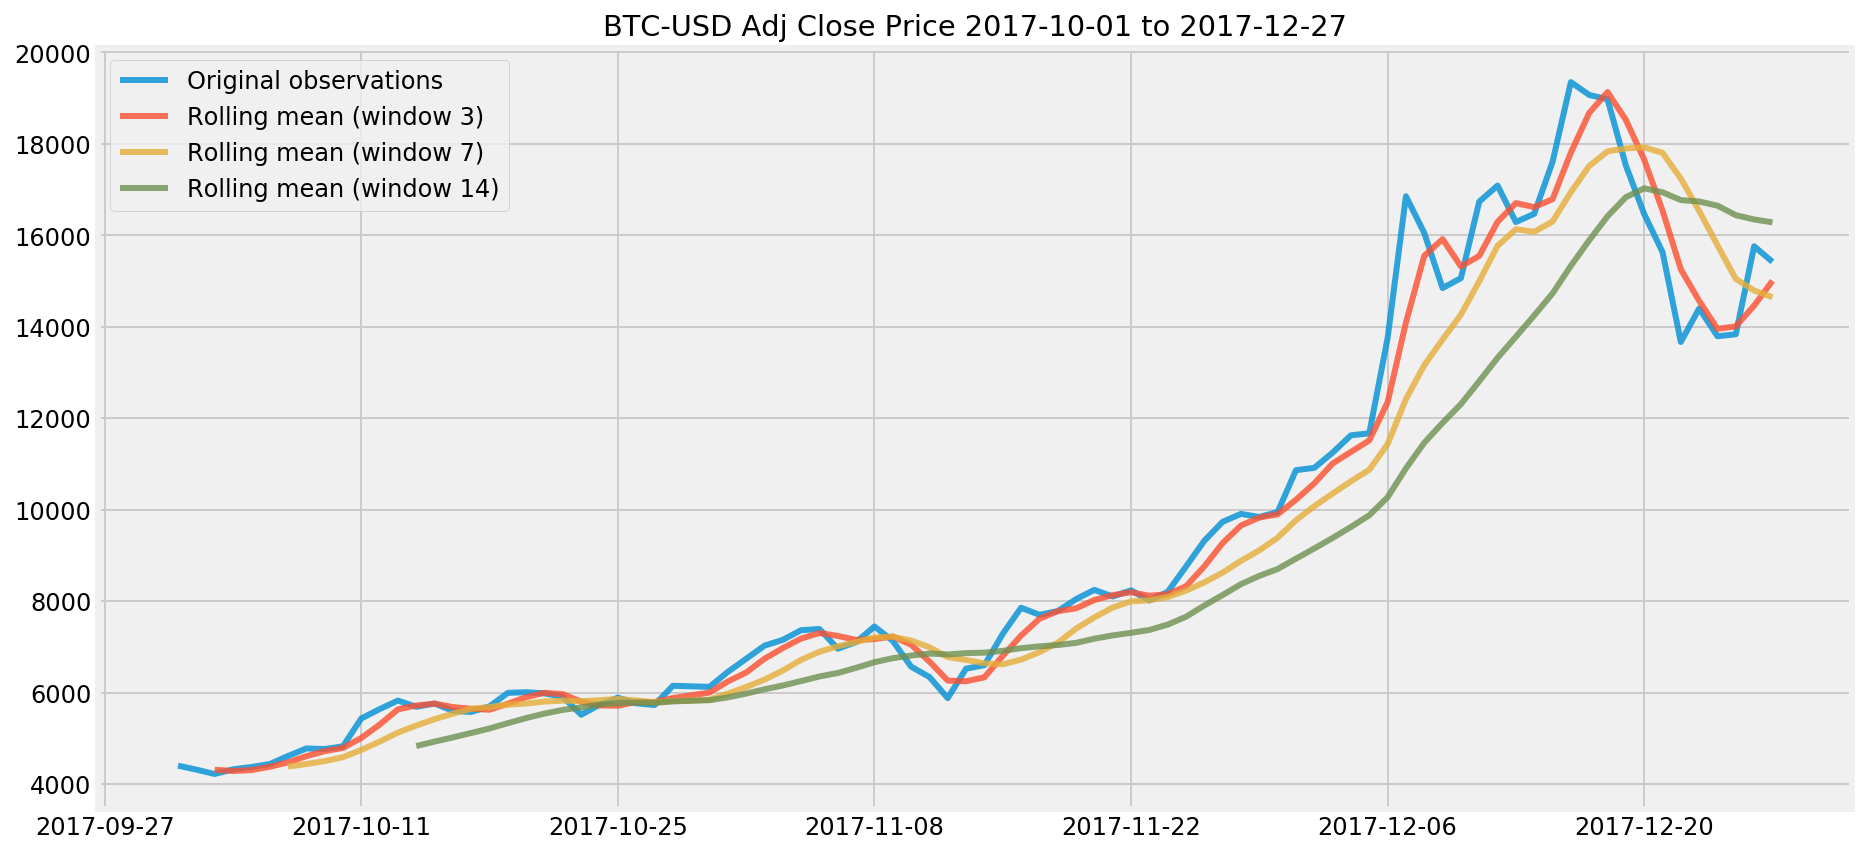

In [4]:
#plot moving avergae results

plt.figure(figsize=(14, 7))
plt.plot(btc_recent.index, btc_recent, lw=3, alpha=0.8,label='Original observations')
plt.plot(btc_recent.index, rroll_d3, lw=3, alpha=0.8,label='Rolling mean (window 3)')
plt.plot(btc_recent.index, rroll_d7, lw=3, alpha=0.8,label='Rolling mean (window 7)')
plt.plot(btc_recent.index, rroll_d14, lw=3, alpha=0.8,label='Rolling mean (window 14)')
plt.title('BTC-USD Adj Close Price 2017-10-01 to 2017-12-27')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [5]:
short_window = 10
mid_window = 50
signals = pd.DataFrame(index=btc_adj.index)
signals['signal'] = 0.0
roll_d10 = btc_adj.rolling(window=short_window).mean()
roll_d50 = btc_adj.rolling(window=mid_window).mean()
signals['short_mavg'] = roll_d10
signals['mid_mavg'] = roll_d50
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['mid_mavg'][short_window:], 1.0, 0.0)
signals['positions'] = signals['signal'].diff()

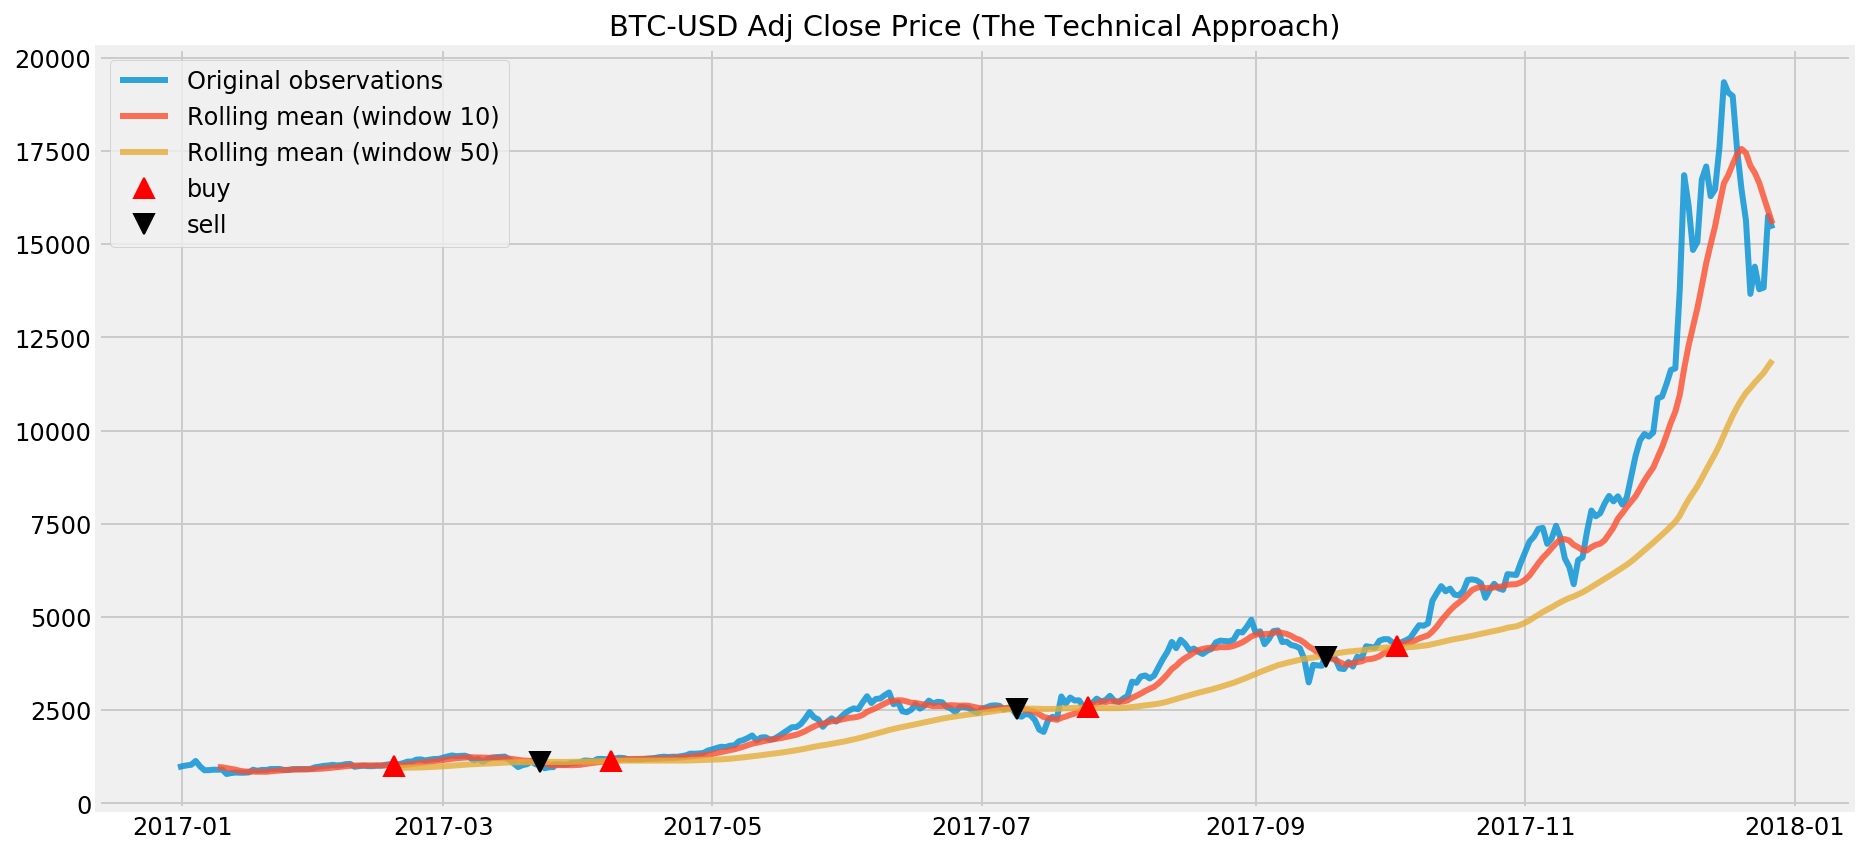

In [6]:
#plot the results

plt.figure(figsize=(14, 7))
plt.plot(btc_adj.index, btc_adj, lw=3, alpha=0.8,label='Original observations')
plt.plot(btc_adj.index, roll_d10, lw=3, alpha=0.8,label='Rolling mean (window 10)')
plt.plot(btc_adj.index, roll_d50, lw=3, alpha=0.8,label='Rolling mean (window 50)')
plt.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='r', label='buy')
         
plt.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k', label='sell')
plt.title('BTC-USD Adj Close Price (The Technical Approach)')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()


In [9]:
initial_investment = btc_adj.loc[list(signals[signals.positions == 1.0].index)][0]
bought = np.sum(btc_adj.loc[list(signals[signals.positions == 1.0].index)]*-1.0)
sold = np.sum(btc_adj.loc[list(signals[signals.positions == -1.0].index)])
current_btc_value = btc_adj[-1]
balance = pd.DataFrame([btc_adj.loc[list(signals[signals.positions == 1.0].index)]*-1.0,
              btc_adj.loc[list(signals[signals.positions == -1.0].index)]]).transpose()
balance = balance.fillna(0)
balance['balance'] = balance.sum(axis=1)

print("Initial investment amount: {0:.2f} USD".format(initial_investment))
print("Maximum invested amount: {0:.2f} USD".format(abs(min(balance.cumsum().balance))))
print("Current asset value: {0:.2f} USD".format(bought+sold+current_btc_value))

Initial investment amount: 1052.28 USD
Maximum invested amount: 1555.16 USD
Current asset value: 13861.48 USD


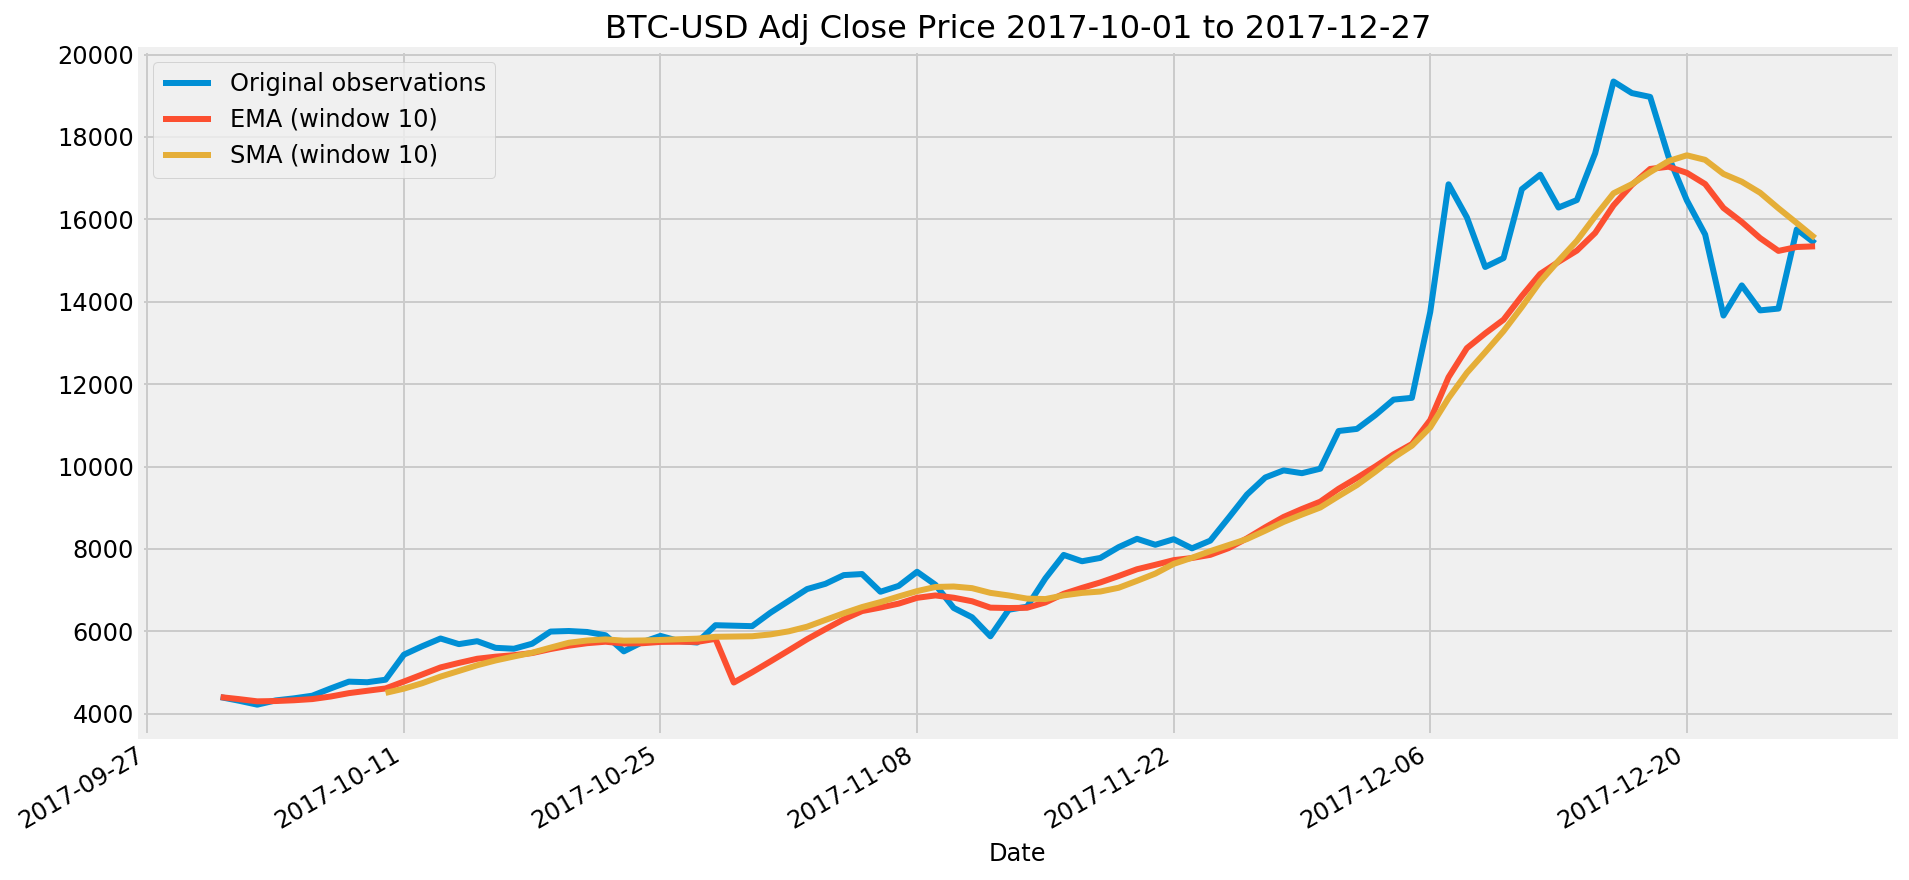

In [10]:
#exponential moving average

exp_weighted_mean = btc_recent.resample('D').sum().ewm(span=10).mean()
sma_d10 = btc_recent.rolling(window=10).mean()
ax = btc_recent.plot(lw=3, figsize=(14, 7), label='Original observations')
exp_weighted_mean.plot(ax=ax, lw=3, label='EMA (window 10)')
sma_d10.plot(ax=ax, lw=3, label='SMA (window 10)')
plt.title('BTC-USD Adj Close Price 2017-10-01 to 2017-12-27', fontsize=16)
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [11]:
exp_weighted_mean = btc_recent.resample('D').sum().ewm(span=20).mean()
signals_ema = pd.DataFrame(index=btc_recent.index)
signals_ema['signal'] = 0.0
signals_ema['original'] = btc_recent
signals_ema['EMA'] = exp_weighted_mean
signals_ema['signal'] = np.where(signals_ema['original'] > signals_ema['EMA'], 1.0, 0.0)
signals_ema['positions'] = signals_ema['signal'].diff()

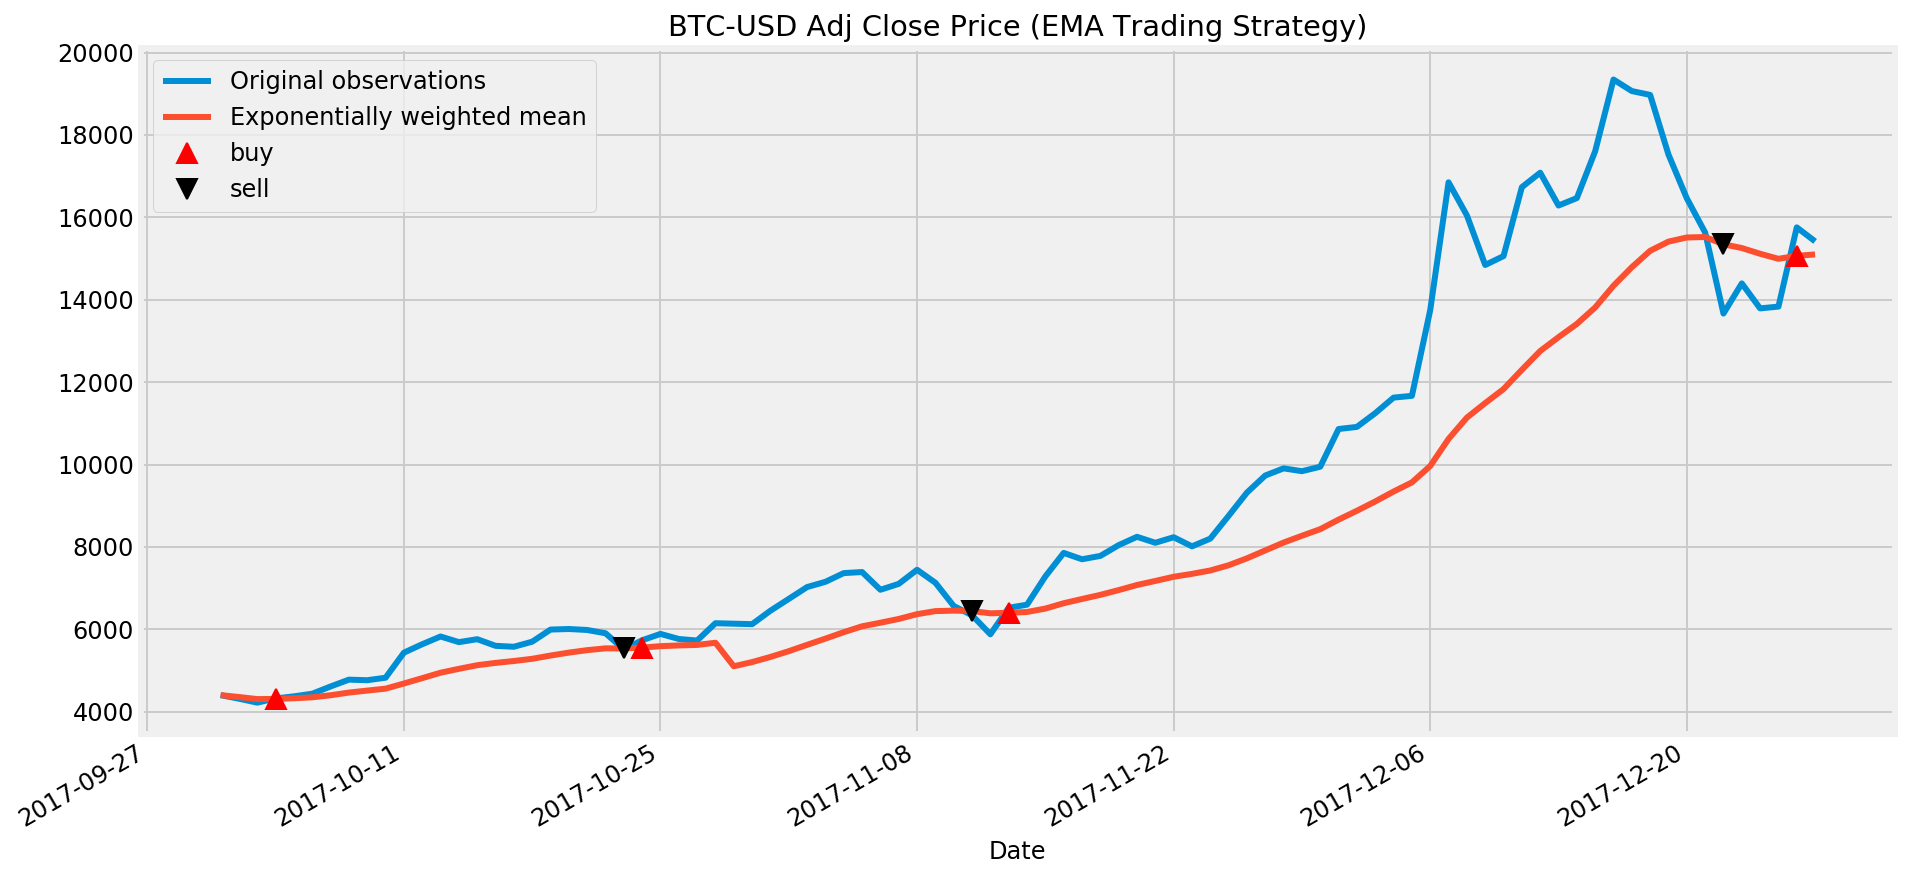

In [12]:
plt.figure(figsize=(14, 7))
ax = btc_recent.plot(lw=3, figsize=(14, 7), label='Original observations')
exp_weighted_mean.plot(ax=ax, lw=3, label='Exponentially weighted mean')
plt.plot(signals_ema.loc[signals_ema.positions == 1.0].index, 
         signals_ema.EMA[signals_ema.positions == 1.0],
         '^', markersize=10, color='r', label='buy')
         
plt.plot(signals_ema.loc[signals_ema.positions == -1.0].index, 
         signals_ema.EMA[signals_ema.positions == -1.0],
         'v', markersize=10, color='k', label='sell')
plt.title('BTC-USD Adj Close Price (EMA Trading Strategy)')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [14]:
initial_investment = btc_recent.loc[list(signals_ema[signals_ema.positions == 1.0].index)][0]
bought = np.sum(btc_recent.loc[list(signals_ema[signals_ema.positions == 1.0].index)]*-1.0)
sold = np.sum(btc_recent.loc[list(signals_ema[signals_ema.positions == -1.0].index)])
current_btc_value = btc_recent[-1]
balance_ema = pd.DataFrame([btc_recent.loc[list(signals_ema[signals_ema.positions == 1.0].index)]*-1.0,
              btc_recent.loc[list(signals_ema[signals_ema.positions == -1.0].index)]]).transpose()
balance_ema = balance_ema.fillna(0)
balance_ema['balance'] = balance_ema.sum(axis=1)
print("Initial investment amount: {0:.2f} USD".format(initial_investment))
print("Maximum invested amount: {0:.2f} USD".format(abs(min(balance_ema.cumsum().balance))))
print("Current asset value: {0:.2f} USD".format(bought+sold+current_btc_value))

Initial investment amount: 4321.44 USD
Maximum invested amount: 6816.54 USD
Current asset value: 8600.10 USD
